In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/itba-cifar-100-2024-q-1/y_train_fine.npy
/kaggle/input/itba-cifar-100-2024-q-1/y_train_coarse.npy
/kaggle/input/itba-cifar-100-2024-q-1/fine_label_names.pck
/kaggle/input/itba-cifar-100-2024-q-1/coarse_label_names.pck
/kaggle/input/itba-cifar-100-2024-q-1/x_test.npy
/kaggle/input/itba-cifar-100-2024-q-1/x_train.npy


Cargo datasets de train, test, y las clases fine (100) y coarse (20).

Divido por 255 para normalizar el RGB a algo entre 0.0 y 1.0

In [2]:
x_train = np.load("/kaggle/input/itba-cifar-100-2024-q-1/x_train.npy")
x_test = np.load("/kaggle/input/itba-cifar-100-2024-q-1/x_test.npy")
y_train = np.load("/kaggle/input/itba-cifar-100-2024-q-1/y_train_fine.npy")

In [3]:
import pickle
with open("/kaggle/input/itba-cifar-100-2024-q-1/fine_label_names.pck", "rb") as f:
    labels_fine = pickle.load(f)

In [4]:
indices_train = np.arange(len(x_train))
np.random.shuffle(indices_train)

x_train = x_train[indices_train]
y_train = y_train[indices_train]

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import plotly.express as px
import numpy as np
%matplotlib inline

## preprocessing & augmentation

In [6]:
from imgaug import augmenters as iaa
import imgaug as ia
from keras.utils import to_categorical
import random

np.bool = np.bool_

2024-06-17 19:57:17.373536: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 19:57:17.373603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 19:57:17.375609: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


> 

In [8]:
train_images = x_train.astype('float32')/255
test_images = x_test.astype('float32')/255

# train_labels = to_categorical(y_train)
train_labels = y_train

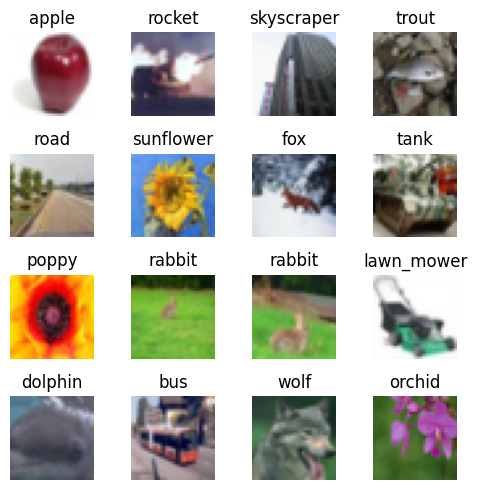

In [9]:
plt.figure(figsize=(5, 5))
for i in range (16):
  rand_num = np.random.randint(0, 50000)
  cifar_img = plt.subplot(4,4, i+1)
  plt.imshow(train_images[rand_num])
  plt.title(labels_fine[train_labels[rand_num]])
  plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
seq = iaa.Sequential([ 
    iaa.Fliplr(1.0), #horizontal mirror, p=01
    iaa.Affine(rotate=(-25,25)), # random degree

    iaa.SomeOf((2, 4),
        [
            iaa.Affine(translate_px={"x": (-5, 5)}),
            iaa.Affine(translate_px={"y": (-5, 5)}),
            iaa.Affine(shear=(-2, 2),mode = ['symmetric','wrap']),#48
            iaa.Affine(scale={"x": (0.90, 1.10), "y": (0.90, 1.10)}),

            iaa.CropAndPad(px=(-2, 2),sample_independently=True,pad_mode=["constant", "edge"]),
    
            iaa.Add((-0.15, 0.15), per_channel=0.5),
            iaa.Multiply((0.95, 1.15), per_channel=0.5),

            iaa.LinearContrast((0.8, 1.4)),
            iaa.Cutout(fill_mode="gaussian", nb_iterations=(1, 4), size=0.10),
        ],random_order=True)
],random_order=True)

In [15]:
aug_test = seq.augment_images(images=train_images[:1000])

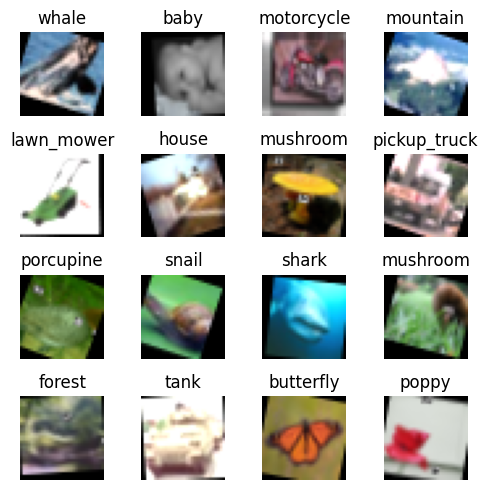

In [16]:
plt.figure(figsize=(5, 5))
for i in range (16):
  rand_num = np.random.randint(0, 1000)
  cifar_img = plt.subplot(4,4, i+1)
  plt.imshow(aug_test[rand_num])
  plt.title(labels_fine[train_labels[rand_num]])
  plt.axis('off')

plt.tight_layout()
plt.show()

In [17]:
train_images_aug1 = seq.augment_images(train_images)
train_images_aug2 = seq.augment_images(train_images)
train_images_aug3 = seq.augment_images(train_images)

In [ ]:
# train_images_aug2 = seq.augment_images(train_images)

In [ ]:
# train_images_aug3 = seq.augment_images(train_images)

In [18]:
train_images_aug_all = []
train_images_aug_all.extend(train_images)
train_images_aug_all.extend(train_images_aug1)
train_images_aug_all.extend(train_images_aug2)
train_images_aug_all.extend(train_images_aug3)

In [19]:
train_labels_aug_all = []
train_labels_aug_all.extend(train_labels)
train_labels_aug_all.extend(train_labels)
train_labels_aug_all.extend(train_labels)
train_labels_aug_all.extend(train_labels)

In [20]:
print(len(train_images_aug_all))
print(len(train_labels_aug_all))

200000
200000


In [21]:
train_images_final = []
train_labels_final = []

combined = list(zip(train_images_aug_all, train_labels_aug_all))
random.shuffle(combined)

train_images_final[:], train_labels_final[:] = zip(*combined)

In [22]:
train_images_final = np.asarray(train_images_final)
train_labels_final = np.asarray(train_labels_final)

In [26]:
# with open('train_images_final.pkl', 'wb') as f:
#     pickle.dump(train_images_final, f)

# with open('train_labels_final.pkl', 'wb') as f:
#     pickle.dump(train_labels_final, f)
    
    
    
# with open('train_images_final.pkl', 'rb') as f:
#     train_images_final = pickle.load(f)

# with open('train_labels_final.pkl', 'rb') as f:
#     train_labels_final = pickle.load(f)

In [23]:
print(train_images_final.shape)
print(train_labels_final.shape)

(200000, 32, 32, 3)
(200000,)


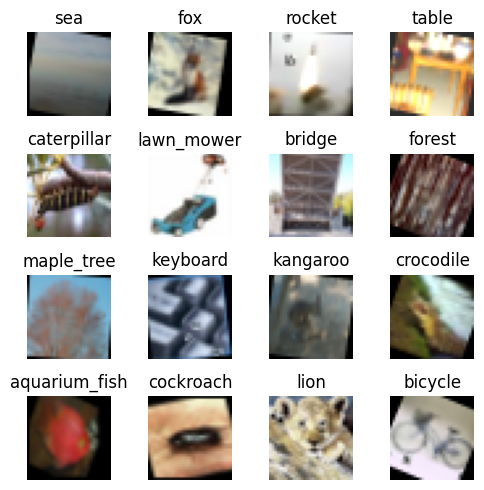

In [25]:
plt.figure(figsize=(5, 5))
for i in range(16):
    rand_num = np.random.randint(0, 150000)
    cifar_img = plt.subplot(4, 4, i + 1)
    plt.imshow(train_images_final[rand_num])
 
    plt.title(labels_fine[train_labels_final[rand_num]]) 
    plt.axis('off')

plt.tight_layout()
plt.show()

## CNNModel

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, Conv2D, Dense, Dropout, BatchNormalization, Flatten, Activation
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import collections

In [54]:
all_history = collections.defaultdict(dict)

In [62]:
num_epochs = 200
batch_size = 128
base_lr = 0.0001

In [63]:
model = Sequential()

# model.add(Conv2D(64, (3, 3), padding='same', activation='relu', strides=(1, 1), input_shape=(32, 32, 3)))

# # CNN
# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same', input_shape=(32,32,3)))
# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same'))
# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(AveragePooling2D(pool_size=(2,2), strides=(2, 2)))

# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same'))
# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same'))
# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(AveragePooling2D(pool_size=(2,2), strides=(2, 2)))

# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same'))
# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same'))
# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(AveragePooling2D(pool_size=(2,2), strides=(2, 2)))

# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same'))
# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same'))
# model.add(Conv2D(16, kernel_size=(2,2), strides=(1, 1), activation='relu', padding='same'))
# model.add(BatchNormalization())
# model.add(AveragePooling2D(pool_size=(2,2), strides=(2, 2)))

# # Clasificador MLP
# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(100, activation='softmax'))

model.add(Conv2D(16, kernel_size=(2, 2), strides=(1, 1), padding='same', activation='relu', input_shape=(32,32,3)))
model.add(Conv2D(16, kernel_size=(2, 2), strides=(1, 1), padding='same', activation='relu') )
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2,2), strides=(2, 2)))

# Increased depth to the Conv2D layers, improving the complexity of the features learned
model.add(Conv2D(32, kernel_size=(2,2), strides=(1, 1), padding='same', activation='relu') )
model.add(Conv2D(32, kernel_size=(2,2), strides=(1, 1), padding='same', activation='relu') )
model.add(Conv2D(32, kernel_size=(2,2), strides=(1, 1), padding='same', activation='relu') )
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2,2), strides=(2, 2)))

# Depth further increased for the final Conv2D layers
model.add(Conv2D(64, kernel_size=(2,2), strides=(1, 1), padding='same', activation='relu') )
model.add(Conv2D(64, kernel_size=(2,2), strides=(1, 1), padding='same', activation='relu') )
model.add(Conv2D(64, kernel_size=(2,2), strides=(1, 1), padding='same', activation='relu') )
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2,2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=base_lr), metrics=['accuracy'])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_58 (Conv2D)              │ (None, 32, 32, 16)     │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 32, 32, 16)     │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_21            │ (None, 16, 16, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 16, 16, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 16, 16, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 16, 16, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_22            │ (None, 8, 8, 32)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 8, 8, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 8, 8, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 8, 8, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_23            │ (None, 4, 4, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,132 (1016.14 KB)

 Trainable params: 259,652 (1014.27 KB)

 Non-trainable params: 480 (1.88 KB)

In [56]:
rlrop = ReduceLROnPlateau(
    monitor = "val_accuracy",
    factor = 0.5,
    patience = 3,
    verbose = 1,
    min_lr = 1e-5
)

In [57]:
mc = ModelCheckpoint(
    ".weights.h5",
    monitor = "val_accuracy",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [58]:
es = EarlyStopping(
    monitor = "val_accuracy",
    patience = 10, 
    verbose = 1,
    restore_best_weights = True,
)

In [35]:
train_labels_final_tweak = to_categorical(train_labels_final)
print(train_labels_final_tweak.shape)
print(train_images_final.shape)

(200000, 100)
(200000, 32, 32, 3)


In [64]:
history = model.fit(x=train_images_final, y=train_labels_final_tweak, batch_size=batch_size, epochs=num_epochs, validation_split=0.2, callbacks=[rlrop, es, mc])

Epoch 1/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.0549 - loss: 4.3572
Epoch 1: val_accuracy improved from -inf to 0.13865, saving model to .weights.h5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 185s 143ms/step - accuracy: 0.0549 - loss: 4.3570 - val_accuracy: 0.1387 - val_loss: 3.7209 - learning_rate: 1.0000e-04
Epoch 2/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.1589 - loss: 3.6061
Epoch 2: val_accuracy improved from 0.13865 to 0.18653, saving model to .weights.h5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 179s 143ms/step - accuracy: 0.1589 - loss: 3.6060 - val_accuracy: 0.1865 - val_loss: 3.4131 - learning_rate: 1.0000e-04
Epoch 3/200
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.2068 - loss: 3.3133
Epoch 3: val_accuracy improved from 0.18653 to 0.21715, saving model to .weights.h5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 180s 144ms/step - accuracy: 0.2068 - loss: 3.3132 - val_accuracy: 0.2172 - val_loss: 3.2364 - learning_rate: 1.0000e-04
Epoch 4/200
1250/1250 ━━━

In [65]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


In [66]:
all_history['case_1_train'] = history.history

In [78]:
print('Train loss:', all_history['case_1_train']['loss'][-1])
print('Train acc:', all_history['case_1_train']['accuracy'][-1])
print('Validation loss:', all_history['case_1_train']['val_loss'][-1])
print('Validation acc:', all_history['case_1_train']['val_accuracy'][-1])

Train loss: 1.3502222299575806
Train acc: 0.6299062371253967
Validation loss: 2.5363991260528564
Validation acc: 0.39387500286102295


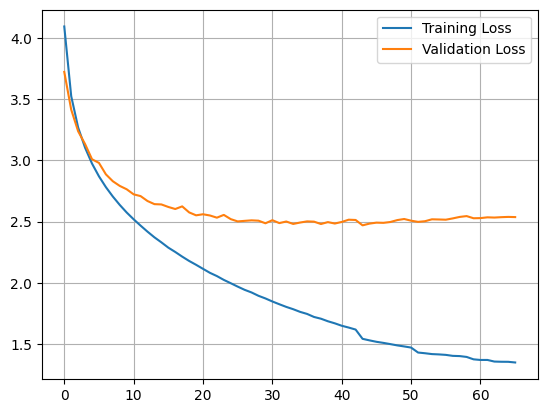

In [68]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.grid()
plt.legend()

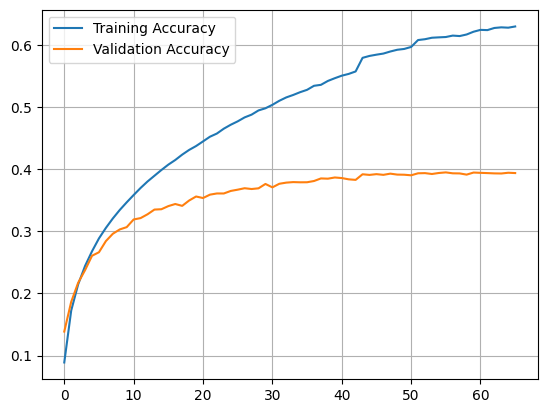

In [69]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.grid()
plt.legend()

In [71]:
test_images_aux = test_images

In [72]:
predictions = model.predict(test_images_aux).argmax(axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


In [73]:
print(predictions.shape)
print(predictions[1])

(10000,)
56


Some predictions:


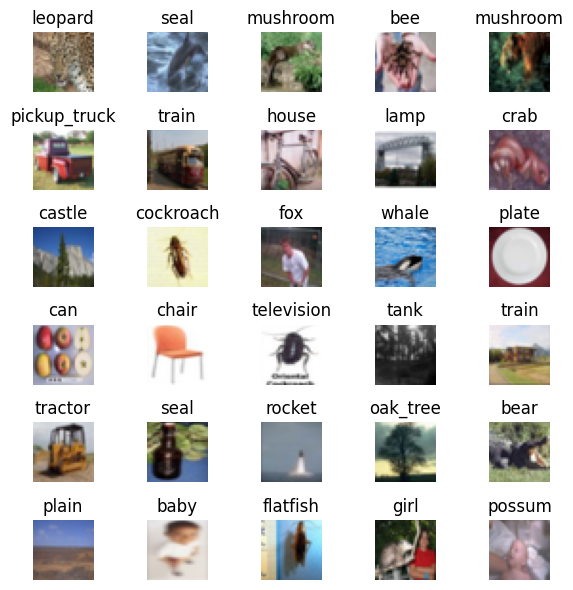

In [76]:
print("Some predictions:")

plt.figure(figsize=(6, 6))
for i in range (30):
  rand_num = np.random.randint(0, 10000)
  cifar_img = plt.subplot(6,5, i+1)
  plt.imshow(test_images_aux[rand_num])
  plt.title(labels_fine[predictions[rand_num]])
  plt.axis('off')

plt.tight_layout()
plt.show()

In [79]:
df = pd.DataFrame(predictions, columns=["Label"])
df.index.name = "Id"
df.head()
df.to_csv("submission.csv")